<a href="https://colab.research.google.com/github/wachirahmuturi/portfolio/blob/main/Building_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.7.0


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import os
import pickle

In [ ]:
class Autoencoder:
  """
  Autoencoder represents a deep convolutional architecture with mirrored encoder and decoder components
  """
  def __init__(self,
               input_shape, #will have 3 dimensions i.e length,width,height describing shape of pixel
               conv_filters, #represents no.of filters per layer e.g. [2,4,8]
               conv_kernels, #represents no.of kernels per layer e.g. [3,4,5]
               conv_strides,
               latent_space_dim):
    self.input_shape = input_shape
    self.conv_filters = conv_filters
    self.conv_kernels = conv_kernels
    self.conv_strides = conv_strides
    self.latent_space_dim = latent_space_dim

    self.encoder = None
    self.decoder = None
    self.model = None

    self._shape_before_bottleneck = None
    self.num_conv_layers = len(conv_filters) #could be either the length of filters/kernels/strides
    self.model_input = None

    self._build()

  def summary(self):
    self.encoder.summary() #possible because this is a keras model
    self.decoder.summary() #possible because this is a keras model
    self.model.summary()

  def compile(self, learning_rate=0.0001):
    optimizer = Adam(learning_rate=learning_rate)
    mse_loss = MeanSquaredError()
    self.model.compile(optimizer=optimizer, loss=mse_loss)

  def train(self, x_train, batch_size, num_epochs):
    self.model.fit(x_train,
                   x_train,
                   batch_size = batch_size,
                   epochs = num_epochs,
                   shuffle=True)
    
  def save(self, save_folder="."):
    self._create_folder_if_it_doesnt_exist(save_folder)
    self._save_parameters(save_folder)
    self._save_weights(save_folder)

  def _create_folder_if_it_doesnt_exist(self, folder):
    if not os.path.exists(folder):
      os.makedirs(folder)

  def _save_parameters(self, save_folder):
    parameters = [
                  self.input_shape,
      self.conv_filters,
      self.conv_kernels,
      self.conv_strides,
      self.latent_space_dim
    ]
    save_path = os.path.join(save_folder, "parameters.pkl")
    with open(save_path, "wb") as f:
      pickle.dump(parameters, f) 

  def _save_weights(self, save_folder):
    save_path = os.path.join(save_folder, "weights.h5")# h5 is a format for saving weights used in keras
    self.model.save_weights(save_path)

  def load_weights(self, weights_path):
    self.model.load_weights(weights_path)

  def reconstruct(self, images):
    latent_representations = self.encoder.predict(images)
    reconstructed_images = self.decoder.predict(latent_representations)
    return reconstructed_images, latent_representations

    
  @classmethod
  def load(cls, save_folder="."):
    params_path = os.path.join(save_folder, "parameters.pkl")
    with open(params_path, "rb") as f:
      parameters = pickle.load(f)
      autoencoder = Autoencoder(*parameters)
      weights_path = os.path.join(save_folder, "weights.h5")
      autoencoder.load_weights(weights_path)
      return autoencoder

  def _build(self):
    self._build_encoder()
    self._build_decoder()
    self._build_autoencoder()

  def _build_autoencoder(self):
    model_input = self.model_input
    model_output = self.decoder(self.encoder(model_input))
    self.model = Model(model_input, model_output, name="autoencoder")

  def _build_decoder(self):
    decoder_input = self._add_decoder_input()
    dense_layer = self._add_dense_layer(decoder_input)
    reshape_layer = self._add_reshape_layer(dense_layer)
    conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
    decoder_output = self._add_decoder_output(conv_transpose_layers)
    self.decoder = Model(decoder_input, decoder_output, name="decoder")

  def _add_decoder_input(self):
    return Input(shape=self.latent_space_dim, name="decoder_input")


  def _add_dense_layer(self, decoder_input):
    #the number of neurons will be the shape before bottleneck but this shape is an array e.g.[2,1,2]
    #so we use the product of the array
    num_neurons = np.prod(self._shape_before_bottleneck)
    dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
    return dense_layer

  def _add_reshape_layer(self, dense_layer):
    #This 1 goes back to a 3d array like what we had before flattening the data in the encoder part
    return Reshape(self._shape_before_bottleneck)(dense_layer)

  def _add_conv_transpose_layers(self, x):
    """Add conv transpose blocks"""
    #Loop through all the conv_transpose layers in reverse order and stop at the 1st layer
    for layer_index in reversed(range(1, self.num_conv_layers)):
      x = self._add_conv_transpose_layer(layer_index, x)
    return x

  def _add_conv_transpose_layer(self, layer_index, x):
    num_layer = self.num_conv_layers - layer_index
    conv_transpose_layer = Conv2DTranspose(
        filters = self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding = 'same',
        name = f"decoder_conv_transpose_layer_{num_layer}"
    )
    x = conv_transpose_layer(x)
    x = ReLU(name=f"decoder_relu_{num_layer}")(x)
    x = BatchNormalization(name=f"decoder_bn_{num_layer}")(x)
    return x

  def _add_decoder_output(self, x):
    conv_transpose_layer = Conv2DTranspose(
        filters = 1, #based on our grey_scale_image_data, we will have 1 channel
        kernel_size = self.conv_kernels[0],
        strides = self.conv_strides[0],
        padding = 'same',
        name = f"decoder_conv_transpose_layer_{self.num_conv_layers}"
    )
    x = conv_transpose_layer(x)
    output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
    return output_layer


  def _build_encoder(self):
    encoder_input = self._add_encoder_input()
    conv_layers = self._add_conv_layers(encoder_input)
    bottleneck = self._add_bottleneck(conv_layers)
    self.model_input = encoder_input
    self.encoder = Model(encoder_input, bottleneck, name='encoder')

  def _add_encoder_input(self):
    return Input(shape=self.input_shape, name='encoder_input')

  def _add_conv_layers(self, encoder_input):
    """Creates convolutional blocks in the encoder"""
    x = encoder_input
    for layer_index in range(self.num_conv_layers):
      x = self._add_conv_layer(layer_index, x)
    return x

  def _add_conv_layer(self, layer_index, x):
    """Adds a convolutional block to a graph of layers, consisting of
    conv 2d, Relu activation + Batch normalization
    """
    layer_number = layer_index + 1
    conv_layer = Conv2D(
        filters = self.conv_filters[layer_index],
        kernel_size = self.conv_kernels[layer_index],
        strides = self.conv_strides[layer_index],
        padding='same',
        name = f"encoder_conv_layer_{layer_number}"
    )

    x = conv_layer(x)
    x = ReLU(name=f"encoder_relu_{layer_number}")(x)
    x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
    return x

  def _add_bottleneck(self, x):
    """Flatten data and add Bottleneck(Dense layer)"""
    #Let's store information about the data before flattening
    self._shape_before_bottleneck = K.int_shape(x)[1:] #In our case this will be a 4d array but the 1st index is not useful
    x = Flatten()(x)
    x = Dense(self.latent_space_dim, name="encoder_output")(x)
    return x


if __name__ == "__main__":
  autoencoder = Autoencoder(
      input_shape = (28, 28, 1),
      conv_filters = (32, 64, 64, 64),
      conv_kernels = (3, 3, 3, 3),
      conv_strides = (1, 2, 2, 1), #where we see 2 means we are down-sampling the data
      latent_space_dim = 2
  )
  autoencoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 28, 28, 32)       320       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 28, 28, 32)        0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 28, 28, 32)       128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 14, 14, 64)       18496     
 D)                                                              
                                                           

In [ ]:
from tensorflow.keras.datasets import mnist

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 20

def load_mnist():
  (x_train, y_train),(x_test, y_test) = mnist.load_data()

  x_train = x_train.astype("float32")/255 # applies normalization
  x_train = x_train.reshape(x_train.shape + (1,)) # adds an extra dimension, the channel dimension
  # do this also for the test set
  x_test = x_test.astype("float32")/255 # applies normalization
  x_test = x_test.reshape(x_test.shape + (1,)) # adds an extra dimension, the channel dimension

  return x_train, y_train, x_test, y_test

def traain(x_train, learning_rate, batch_size, num_epochs):
  #as a 1st step, we want to instantiate an autoencoder object
  autoencoder = Autoencoder(
      input_shape = (28, 28, 1),
      conv_filters = (32, 64, 64, 64),
      conv_kernels = (3, 3, 3, 3),
      conv_strides = (1, 2, 2, 1), #where we see 2 means we are down-sampling the data
      latent_space_dim = 2
  )
  autoencoder.summary()
  autoencoder.compile(learning_rate)
  autoencoder.train(x_train, batch_size, num_epochs)
  return autoencoder

if __name__ == "__main__":
  #x_train, y_train, x_test, y_test = load_mnist()
  x_train, _, _, _ = load_mnist() #we are only concerned with the x_train for now
  autoencoder = traain(x_train[:10000], LEARNING_RATE, BATCH_SIZE, EPOCHS)
  autoencoder.save("model")
  autoencoder2 = Autoencoder.load("model")
  autoencoder2.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 28, 28, 32)       320       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 28, 28, 32)        0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 28, 28, 32)       128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 14, 14, 64)       18496     
 D)                                                              
                                                           

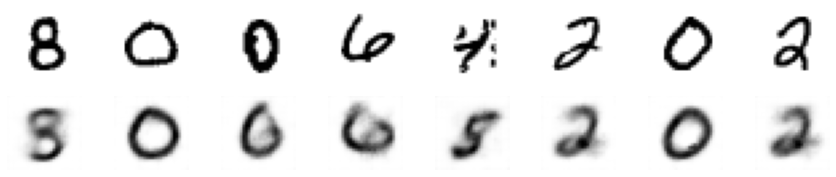

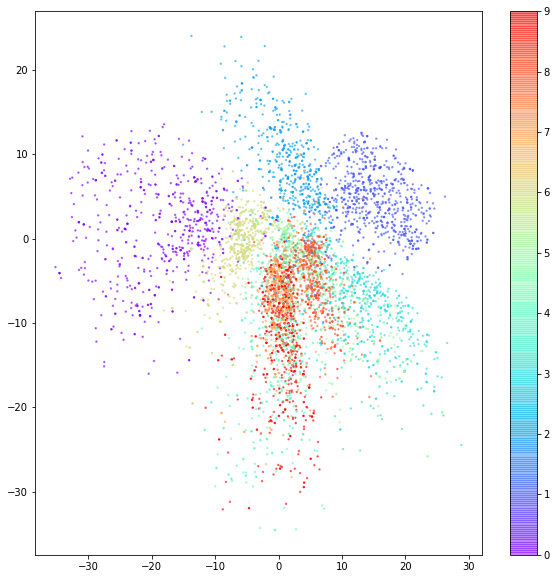

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def select_images(images, labels, num_images=10):
  sample_images_index = np.random.choice(range(len(images)), num_images)
  sample_images = images[sample_images_index]
  sample_labels = labels[sample_images_index]
  return sample_images, sample_labels

def plot_reconstructed_images(images, reconstructed_images):
  fig = plt.figure(figsize=(15, 3))
  num_images = len(images)
  for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
    image = image.squeeze()
    ax = fig.add_subplot(2, num_images, i+1)
    ax.axis("off")
    ax.imshow(image, cmap="gray_r")
    reconstructed_image = reconstructed_image.squeeze()
    ax = fig.add_subplot(2, num_images, i+num_images + 1)
    ax.axis("off")
    ax.imshow(reconstructed_image, cmap="gray_r")
  plt.show()

def plot_images_encoded_in_latent_space(latent_representations, sample_labels):
  plt.figure(figsize=(10,10))
  plt.scatter(latent_representations[:, 0],
              latent_representations[:, 1],
              cmap="rainbow",
              c=sample_labels,
              alpha=0.5,
              s=2)
  plt.colorbar()
  plt.show()

if __name__ == "__main__":
  autoencoder = Autoencoder.load("/content/model") #we're passing the model folder containing our params + weights
  x_train, y_train, x_test, y_test = load_mnist()

  num_sample_images_to_show = 8
  sample_images, _ = select_images(x_test, y_test, num_sample_images_to_show)
  reconstructed_images, _ = autoencoder.reconstruct(sample_images)
  plot_reconstructed_images(sample_images, reconstructed_images)
#Create a scatter plot visualization of the bottleneck representation
  num_images= 6000
  sample_images, sample_labels = select_images(x_test, y_test, num_images)
  _, latent_representations = autoencoder.reconstruct(sample_images)
  plot_images_encoded_in_latent_space(latent_representations, sample_labels)
